In [1]:
!pip install -q tensorflowjs
!nvidia-smi

Sat Jan 15 22:00:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Runtime
use_tpu = False #@param


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [4]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/insoluble.npz",
    "insoluble.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/soluble.npz",
    "soluble.npz",
)
with np.load("soluble.npz") as r:
    pos_data = r['arr_0']
with np.load("insoluble.npz") as r:
    neg_data = r['arr_0']

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)

In [5]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 8785
Negative data 9668


In [6]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=148,
                hidden_dim=128,
                embedding_dim=96,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.3
               )



In [7]:
def build_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)
    counts = tf.keras.layers.GlobalAveragePooling1D()(e)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(e)
    x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalAveragePooling1D()(e)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(e)
    x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn-infer')
    return model

In [8]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [9]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
data = tf.data.Dataset.from_tensor_slices((features, labels))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)

  # 50 epochs
  decay_steps = N  // config.batch_size * 50
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [11]:
model.summary()

Model: "sol-rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 96)     2016        ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 296)         290080      ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling1d (Glob  (None, 96)          0           ['embedding[0][0]']        

In [12]:
# model.fit(
#     train_data, 
#     validation_data=val_data, 
#     callbacks=[tf.keras.callbacks.LambdaCallback(
#         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
#         )],
#     epochs=100)

result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
          tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=6)],
    epochs=150)



lr = 0.001
Epoch 1/150
923/923 [==============================] - 37s 32ms/step - loss: 0.6778 - auc: 0.6012 - binary_accuracy: 0.5800 - val_loss: 0.6374 - val_auc: 0.6728 - val_binary_accuracy: 0.6412
lr = 0.0009993684
Epoch 2/150
923/923 [==============================] - 27s 29ms/step - loss: 0.6425 - auc: 0.6594 - binary_accuracy: 0.6307 - val_loss: 0.6283 - val_auc: 0.6914 - val_binary_accuracy: 0.6314
lr = 0.0009974748
Epoch 3/150
923/923 [==============================] - 27s 29ms/step - loss: 0.6269 - auc: 0.6792 - binary_accuracy: 0.6409 - val_loss: 0.6195 - val_auc: 0.6876 - val_binary_accuracy: 0.6363
lr = 0.0009943242
Epoch 4/150
923/923 [==============================] - 26s 28ms/step - loss: 0.6165 - auc: 0.6875 - binary_accuracy: 0.6453 - val_loss: 0.6070 - val_auc: 0.7067 - val_binary_accuracy: 0.6493
lr = 0.0009899247
Epoch 5/150
923/923 [==============================] - 26s 28ms/step - loss: 0.6097 - auc: 0.6975 - binary_accuracy: 0.6512 - val_loss: 0.6053 - val_auc:

116/116 [==============================] - 1s 11ms/step - loss: 0.6045 - auc: 0.7342 - binary_accuracy: 0.6737


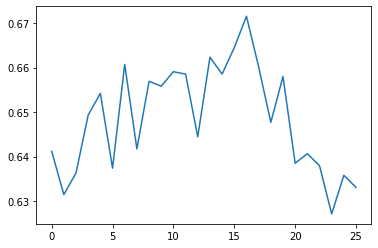

In [13]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [14]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [15]:
inference_model.predict(np.array([1,1,1,0,0,0,0]).reshape(1,-1))

array([[0.32470626]], dtype=float32)

In [16]:
tfjs.converters.save_keras_model(inference_model, "tfjs_model")

# Model Card

In [17]:
model_card = {
    'title': 'Solubility Prediction',
    'details': 'Recurrent (GRU) neural network for predicting solubility. Developed by Andrew White using data from PROSO II database in TFJS.',
    'use': 'Peptides or proteins expressed in E. coli that are less than 200 residues long. May provide solubility predictions more broadly applicable.',
    'factors': 'Solubility was defined in PROSO II as sequence that was transfectible, expressible, secretable, separable, and soluble in E. coli system.',
    'metrics': f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}',
    'evaluation': 'Withheld positive and negative examples',
    'training': f'{len(pos_data) + len(neg_data)} positive and negative sequences.',
    'caveats': 'This data is mostly long sequences and so may not be as applicable to solid-phase synthesized peptides. The model accuracy is low.',
    'ethics': 'None noted'
}
with open('card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Solubility Prediction",
 "details": "Recurrent (GRU) neural network for predicting solubility. Developed by Andrew White using data from PROSO II database in TFJS.",
 "use": "Peptides or proteins expressed in E. coli that are less than 200 residues long. May provide solubility predictions more broadly applicable.",
 "factors": "Solubility was defined in PROSO II as sequence that was transfectible, expressible, secretable, separable, and soluble in E. coli system.",
 "metrics": "Test accuracy 0.67. Test AUC 0.73",
 "evaluation": "Withheld positive and negative examples",
 "training": "18453 positive and negative sequences.",
 "caveats": "This data is mostly long sequences and so may not be as applicable to solid-phase synthesized peptides. The model accuracy is low.",
 "ethics": "None noted"
}
